In [2]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import mysql.connector
import json
from collections import Counter
import os
import re
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [4]:
target="kiwi"

'tomato','basil','cheese_mozzarella_low_moisture_part_skim','olive_oil'
         aroma_id  food_count  total_ratio
0           fatty           2      0.47662
1           faint           3      0.23864
2   slightly_waxy           2      0.21558
3            mild           3      0.14889
4          bitter           3      0.09501
5           yeast           2      0.09484
6           bread           2      0.09484
7           baked           2      0.09484
8           sweet           1      0.04034
9           green           1      0.02051
10        vanilla           1      0.02051
11          spice           1      0.02051
12       licorice           1      0.02051
13        alcohol           1      0.02051
14     sassafrass           1      0.02051
15          minty           1      0.02051
16         fennel           1      0.02051
17          anise           1      0.02051
18         herbal           1      0.02051
19         floral           1      0.01983
20       lavender        

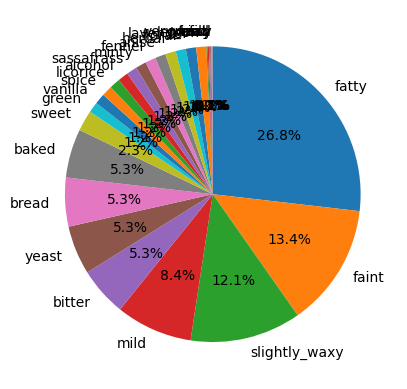

'oyster_raw','kiwi','cucumber'
         aroma_id  food_count  total_ratio
0           fatty           2      0.26633
1           faint           2      0.18822
2          bitter           3      0.07266
3   slightly_waxy           2      0.06829
4            waxy           2      0.05494
5           fried           1      0.05442
6             fat           1      0.05442
7            lard           1      0.05442
8            mild           2      0.03200
9           baked           2      0.01603
10          yeast           1      0.01231
11          bread           1      0.01231
12         grassy           1      0.00428
13      very_mild           1      0.00428
14        coconut           1      0.00052
15          soapy           1      0.00052


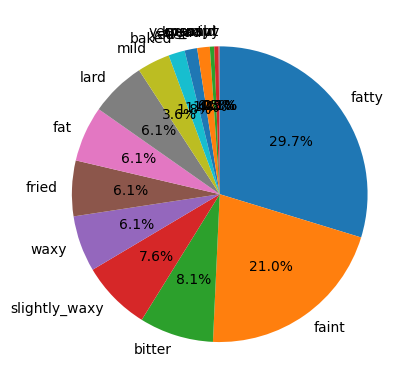

'potato','onion','ham_minced','rye_bread','cheese','mayonnaise'
         aroma_id  food_count  total_ratio
0           fatty           4      0.42303
1           faint           4      0.30253
2          bitter           4      0.14516
3   slightly_waxy           4      0.09486
4            mild           4      0.09024
5           baked           3      0.04364
6           bread           3      0.04364
7           yeast           3      0.04364
8        balsamic           1      0.00540
9        phenolic           1      0.00540
10        coconut           2      0.00397
11          soapy           2      0.00397
12           waxy           2      0.00397
13      very_mild           2      0.00266
14         grassy           2      0.00266
15          fried           1      0.00060


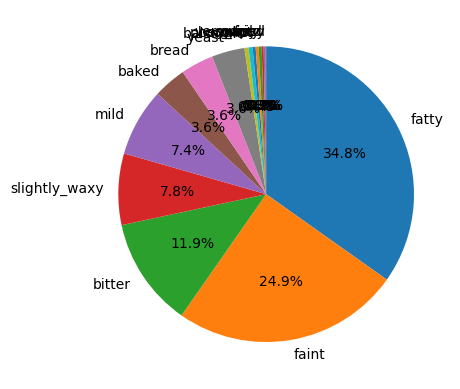

In [15]:
targets=[
    ["tomato", "basil", "mozzarella cheese", "olive oil"],
    ["oyster", "kiwi", "cucumber"],
    ["potato", "onion", "ham", "bread", "cheese", "mayonnaise"],
]

def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_sub_index_text_search", $search_term)
    YIELD node, score
    ORDER BY score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, score    
    """
    return tx.run(find_food_query, search_term=search_term).data()

def find_aromas(tx, ids):
    find_aromas_query = f"""
    MATCH (f:FoodSubType)-[r:SCENTED]->(a:Aroma)
    WHERE f.id IN [{ids}]
    WITH a.id AS aroma_id, COUNT(f) AS food_count, SUM(r.ratio) AS total_ratio
    RETURN aroma_id, food_count, total_ratio
    ORDER BY total_ratio DESC;
    """
    print(ids)
    return tx.run(find_aromas_query).data()
    
with driver.session() as session:
    for dish in targets:
        node_ids = []
        for target in dish:
            result1 = session.execute_read(find_food, target)  
            for record in result1:
                node_ids.append("'"+ record["node_id"] + "'")
    
        result2 = session.execute_read(find_aromas, ",".join(node_ids))
        pd_result = pd.DataFrame(result2)
        print(pd_result)
        
        plt.pie(
            pd_result['total_ratio'], 
            labels=pd_result['aroma_id'], 
            autopct='%1.1f%%',  # 割合表示
            startangle=90,  # 開始角度を指定
            counterclock=False  # 時計回りに表示
        )
        plt.show()
        plt.close()